# Comparing a USGSCSM and ISIS camera for Kaguya Terrain Camera

In [ ]:
import pvl
import os
import tempfile
import csmapi
import json

import knoten
import ale
from knoten import vis
from ale.drivers.selene_drivers import KaguyaTcPds3NaifSpiceDriver
from ale.formatters.usgscsm_formatter import to_usgscsm
from ale import util
from IPython.display import Image
from pysis import isis
from pysis.exceptions import ProcessError

import plotly
plotly.offline.init_notebook_mode(connected=True)

## Make a CSM sensor model
Requires TC1S2B0_01_02842S506E1942.img in data directory

In [2]:
fileName = 'data/TC1S2B0_01_02842S506E1942.img'
camera = knoten.csm.create_csm(fileName)

## Ingest the image and spiceinit

In [3]:
cub_loc = os.path.splitext(fileName)[0] + '.cub'

try: 
    isis.kaguyatc2isis(from_=fileName, to=cub_loc)
except ProcessError as e:
    print(e.stderr)    
    
try:
    isis.spiceinit(from_=cub_loc, shape='ellipsoid')
except ProcessError as e:
    print(e.stderr)
    
kernels = util.generate_kernels_from_cube(cub_loc, expand=True)

usgscsm_str = ale.loads(fileName, props={'kernels': kernels}, formatter='usgscsm', verbose=False)

csm_isd = os.path.splitext(fileName)[0] + '.json'
with open(csm_isd, 'w') as isd_file:
    usgscsm_json = json.loads(usgscsm_str)
    # usgscsm_json['optical_distortion']['kaguyalism'] = {'x': [0, 0, 0, 0], 'y': [0, 0, 0, 0], 'boresight_x': 0, 'boresight_y':0}
    usgscsm_str = json.dumps(usgscsm_json)
    isd_file.write(usgscsm_str)

In [4]:
usgscsm_json = json.loads(usgscsm_str)
n_lines = usgscsm_json['image_lines']
n_samples = usgscsm_json['image_samples']

## Compare USGS CSM and ISIS pixels

In [5]:
csmisis_diff_lv_plot, csmisis_diff_ephem_plot, external_orientation_data = vis.external_orientation_diff(csm_isd, cub_loc, n_lines, n_samples, nx=10, ny=50, width=600, height=600)

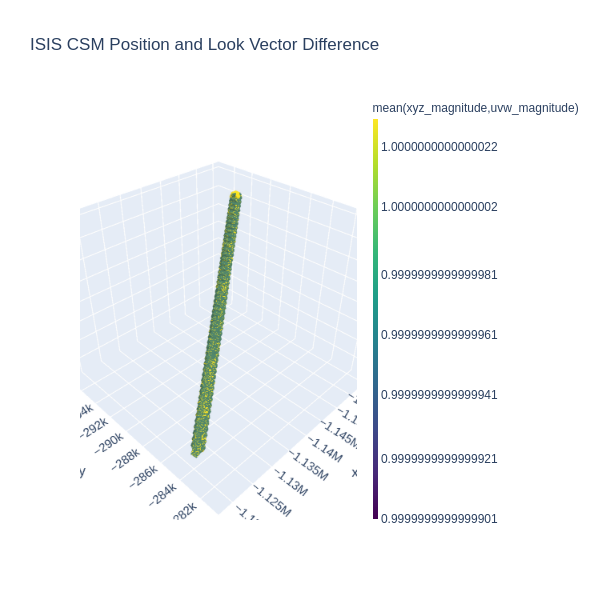

In [6]:
csmisis_diff_lv_plot_bytes = csmisis_diff_lv_plot.to_image(format="png")
csmisis_diff_ephem_plot_bytes = csmisis_diff_ephem_plot.to_image(format="png")
Image(csmisis_diff_lv_plot_bytes)

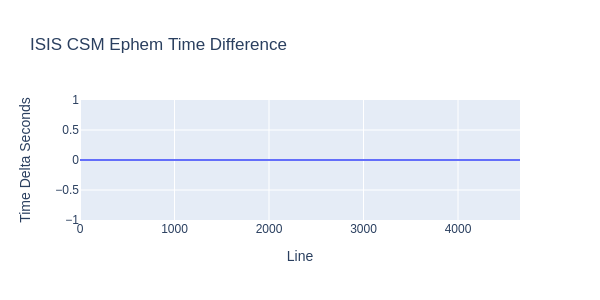

In [7]:
Image(csmisis_diff_ephem_plot_bytes)

In [8]:
external_orientation_data[['diffx', 'diffy', 'diffz', 'diffu', 'diffv', 'diffw']].describe()

,diffx,diffy,diffz,diffu,diffv,diffw
count,5.000000e+02,5.000000e+02,500.000000,5.000000e+02,5.000000e+02,5.000000e+02
mean,-1.582241e-04,4.160451e-05,-0.000317,-6.019209e-09,1.332082e-08,3.254109e-09
std,2.440481e-04,7.481368e-05,0.000238,5.434347e-08,1.298362e-07,6.267006e-08
min,-5.338576e-04,-9.474705e-05,-0.000796,-2.702342e-07,-3.039017e-07,-1.998557e-07
25%,-3.423269e-04,-9.530922e-07,-0.000427,-1.376990e-08,-3.486268e-08,-1.662672e-08
50%,-1.931420e-04,5.391001e-05,-0.000304,-5.436621e-10,1.410718e-10,2.908198e-09
75%,2.002344e-08,1.056908e-04,-0.000129,1.127156e-08,5.034687e-08,2.329107e-08
max,3.018233e-04,1.504507e-04,0.000023,1.385379e-07,5.859448e-07,1.486245e-07


In [9]:
isis2csm_plot, csm2isis_plot, isiscsm_plotlatlon, isiscsm_plotbf, isis2csm_data, csm2isis_data, isiscsm_latlondata, isiscsm_bfdata = vis.reprojection_diff(csm_isd, cub_loc, n_lines, n_samples, nx=10, ny=50, width=600, height=600)

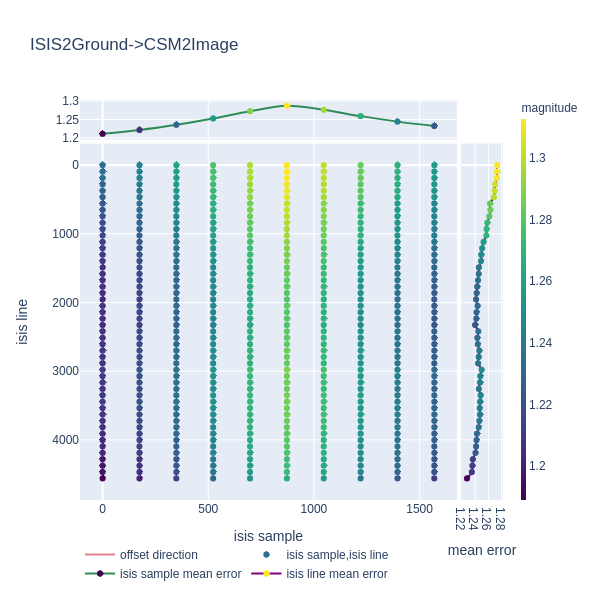

In [10]:
Image(isis2csm_plot.to_image())

In [11]:
isis2csm_data[['diff line', 'diff sample']].describe()

,diff line,diff sample
count,500.000000,500.000000
mean,-1.242138,0.009946
std,0.030566,0.130152
min,-1.312050,-0.205882
25%,-1.268244,-0.104079
50%,-1.244162,0.008900
75%,-1.217202,0.125779
max,-1.174467,0.225041


In [12]:
csm2isis_plot

In [13]:
csm2isis_data[['diff line', 'diff sample']].describe()

,diff line,diff sample
count,500.000000,5.000000e+02
mean,0.000031,1.596472e-04
std,0.000701,1.386055e-03
min,-0.002192,-2.994121e-03
25%,-0.000208,-3.615079e-04
50%,0.000024,5.001084e-10
75%,0.000286,4.640923e-04
max,0.001539,6.426349e-03


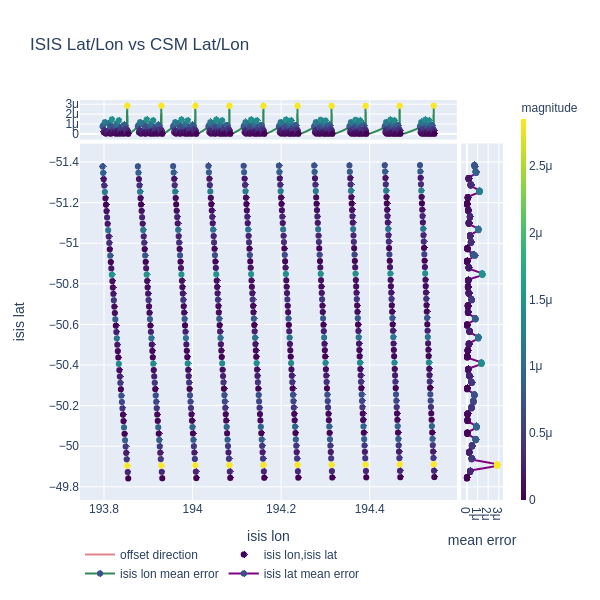

In [14]:
Image(isiscsm_plotlatlon.to_image())

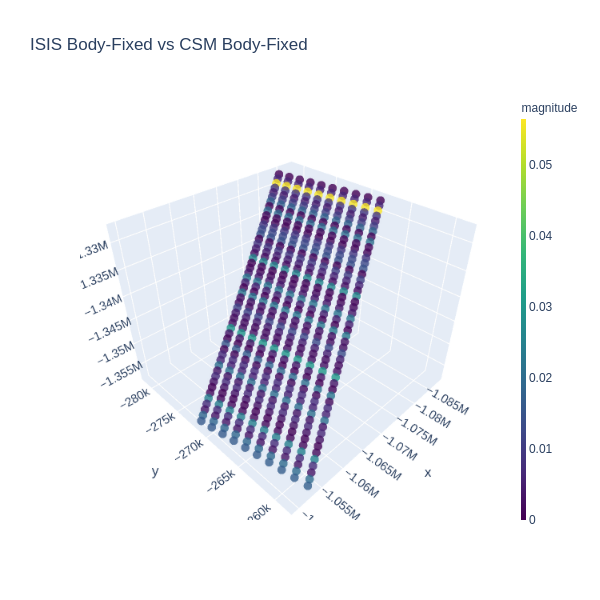

In [15]:
Image(isiscsm_plotbf.to_image())

In [16]:
isiscsm_bfdata[['diffx', 'diffy', 'diffz']].describe()

,diffx,diffy,diffz
count,500.000000,500.000000,500.000000
mean,0.238123,-0.001291,-0.000127
std,1.920749,0.011714,0.004498
min,-3.125287,-0.051489,-0.009667
25%,-0.905023,-0.004994,-0.001689
50%,-0.035097,-0.000023,-0.000089
75%,2.195809,0.003087,0.001401
max,3.113410,0.028289,0.014185
